In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Functions to build the tree

In [51]:
# Function to build a binomial tree for ZCB option prices
def build_option_tree(FaceValue, StrikePrice, ExpiryDate, ZCBMaturity, r0, u, d, option_type='call', redemption_type = "European", q = None, RiskfreeRate = None): # default is a european call option
    option_tree = np.zeros((ExpiryDate+1, ExpiryDate+1))
    if RiskfreeRate is not None and q is None:
        q = (r - d) / (u - d)
    elif RiskfreeRate is None and q is None:
        q = 0.5
    ZCB_structure = FaceValue * ZCB_term_structure(r0, u, d, ZCBMaturity, q)
    term_structure = build_term_structure(r0, u, d, ExpiryDate)
    n=ExpiryDate
    for j in range(n+1):
        if option_type == 'call':
            option_tree[j, n] = max(0, ZCB_structure[j, n] - StrikePrice)
        elif option_type == 'put':
            option_tree[j, n] = max(0, StrikePrice - ZCB_structure[j, n])
    for i in range(n-1, -1, -1):
        for j in range(i+1):
            if redemption_type == "European":
                option_tree[j, i] = (1/(1+term_structure[j, i])) * (q * option_tree[j, i+1] + (1-q) * option_tree[j+1, i+1])
            elif redemption_type == "American":
                if option_type == 'call':
                    option_tree[j, i] = max(ZCB_structure[j, i] - StrikePrice, (1/(1+term_structure[j, i])) * (q * option_tree[j, i+1] + (1-q) * option_tree[j+1, i+1]))
                elif option_type == 'put':
                    option_tree[j, i] = max(StrikePrice - ZCB_structure[j, i], (1/(1+term_structure[j, i])) * (q * option_tree[j, i+1] + (1-q) * option_tree[j+1, i+1]))
    return option_tree

# Function to build the term structure of interest rates
def build_term_structure(r0, u, d, n):
    term_structure = np.zeros((n+1, n+1))
    for i in range(n+1):
        for j in range(i+1):
            term_structure[j, i] = r0 * (u ** (i-j)) * (d ** j)
    return term_structure

def ZCB_term_structure(r0, u, d, TimetoMaturity, q = None, RiskfreeRate = None):
    n = TimetoMaturity
    term_structure = build_term_structure(r0, u, d, n-1)
    ZCB = np.zeros((n+1, n+1))

    if RiskfreeRate is not None and q is None:
        q = (r - d) / (u - d)
    elif RiskfreeRate is None and q is None:
        q = 0.5
        
    # Set the bond value at last i for all j as 1
    ZCB[:, n] = 1

    # Discount the values based on risk neutral probabilities q and 1-q and the term-structure at that node
    for i in range(n-1, -1, -1):
        for j in range(i+1):
            ZCB[j, i] = (q * ZCB[j, i+1] + (1-q) * ZCB[j+1, i+1]) / (1 + term_structure[j, i])
    
    return ZCB

def coupon_bond_term_structure(r0, u, d, TimetoMaturity, FaceValue, couponRate = 0, q = 0.5, RiskfreeRate = None):
    term_structure = build_term_structure(r0, u, d, TimetoMaturity-1)
    coupon_ts = np.zeros((TimetoMaturity+1, TimetoMaturity+1))
    if RiskfreeRate is not None and q is None:
        q = (r - d) / (u - d)
    
    coupon_ts[:,TimetoMaturity] = FaceValue * (1 + couponRate)
    for i in range(TimetoMaturity-1, -1, -1):
        for j in range(i+1):
            coupon_ts[j, i] = (q * coupon_ts[j, i+1] + (1-q) * coupon_ts[j+1, i+1]) / (1 + term_structure[j, i]) + FaceValue * couponRate
    return coupon_ts


def price_ZCB(r0, u, d, TimetoMaturity, FaceValue):
    
    ZCB = ZCB_term_structure(r0, u, d, TimetoMaturity)
    return FaceValue*ZCB[0,0]

def price_futures(r0, u, d, FuturesTime, TimetoMaturity, FaceValue, q = 0.5, couponRate = 0):
    if FuturesTime > TimetoMaturity:
        raise ValueError("FuturesTime cannot be greater than TimetoMaturity")
    bond = coupon_bond_term_structure(r0, u, d, TimetoMaturity, FaceValue, couponRate)
    Futures = np.zeros((FuturesTime+1, FuturesTime+1))
    for j in range(FuturesTime+1):
        Futures[j, FuturesTime] = bond[j, FuturesTime] - couponRate*FaceValue
    for i in range(FuturesTime-1, -1, -1):
        for j in range(i+1):
            Futures[j, i] = (q * Futures[j, i+1] + (1-q) * Futures[j+1, i+1])
    return Futures[0,0]

def price_forwards(r0, u, d, ForwardTime, TimetoMaturity, FaceValue, q = 0.5, couponRate = 0):
    if ForwardTime > TimetoMaturity:
        raise ValueError("ForwardTime cannot be greater than TimetoMaturity")
    bond = coupon_bond_term_structure(r0, u, d, TimetoMaturity, FaceValue, couponRate)
    term_structure = build_term_structure(r0, u, d, ForwardTime)
    Forward = np.zeros((ForwardTime+1, ForwardTime+1))
    for j in range(ForwardTime+1):
        Forward[j, ForwardTime] = bond[j, ForwardTime] - couponRate*FaceValue
    for i in range(ForwardTime-1, -1, -1):
        for j in range(i+1):
            Forward[j, i] = (q * Forward[j, i+1] + (1-q) * Forward[j+1, i+1]) / (1 + term_structure[j, i])
    return 100 * Forward[0,0]/price_ZCB(r0, u, d, ForwardTime, FaceValue)

def price_swaps(r0, u, d, TimetoMaturity, FixedRate, q = 0.5):
    swap = np.zeros((TimetoMaturity, TimetoMaturity))
    term_structure = build_term_structure(r0, u, d, TimetoMaturity-1)
    for j in range(TimetoMaturity):
        swap[j, TimetoMaturity-1] = (term_structure[j,TimetoMaturity-1] - FixedRate)/(1 + term_structure[j,TimetoMaturity-1])
    for i in range(TimetoMaturity-2, -1, -1):
        for j in range(i+1):
            swap[j, i] = ( term_structure[j,i] - FixedRate + q * swap[j, i+1] + (1-q) * swap[j+1, i+1]) / (1 + term_structure[j, i])
    return swap[0,0]

def price_swaption(r0, u, d, SwaptionTime, TimetoMaturity, FixedRate, redemptionType = "European", q = 0.5):
    swap = np.zeros((TimetoMaturity, TimetoMaturity))
    term_structure = build_term_structure(r0, u, d, TimetoMaturity-1)
    for j in range(TimetoMaturity):
        swap[j, TimetoMaturity-1] = (term_structure[j,TimetoMaturity-1] - FixedRate)/(1 + term_structure[j,TimetoMaturity-1])
    for i in range(TimetoMaturity-2, -1, -1):
        for j in range(i+1):
            swap[j, i] = ( term_structure[j,i] - FixedRate + q * swap[j, i+1] + (1-q) * swap[j+1, i+1]) / (1 + term_structure[j, i])
    swaption = np.zeros((SwaptionTime+1, SwaptionTime+1))
    for j in range(SwaptionTime+1):
        swaption[j, SwaptionTime] = max(0, swap[j, SwaptionTime])
    for i in range(SwaptionTime-1, -1, -1):
        for j in range(i+1):
            if redemptionType == "European":
                swaption[j, i] = (1/(1+term_structure[j, i])) * (q * swaption[j, i+1] + (1-q) * swaption[j+1, i+1])
            elif redemptionType == "American":
                swaption[j, i] = max(swap[j, i], (1/(1+term_structure[j, i])) * (q * swaption[j, i+1] + (1-q) * swaption[j+1, i+1]))
    return swaption[0,0]

def elementary_prices_lattice(r0, u, d, n, q = 0.5):
    term_structure = build_term_structure(r0, u, d, n)
    elementary = np.zeros((n+1, n+1))
    elementary[0,0] = 1
    for i in range(1, n+1):
        elementary[0,i] = q * elementary[0,i-1] / (1 + term_structure[0,i-1])
        elementary[i,i] = (1-q) * elementary[i-1,i-1] / (1 + term_structure[i-1,i-1])
        for j in range(1, i):
            elementary[j,i] = q * elementary[j,i-1] / (1 + term_structure[j,i-1]) + (1-q) * elementary[j-1,i-1] / (1 + term_structure[j-1,i-1])

    return elementary

In [19]:
# Parameters
S0 = 100  # Initial stock price
K = 100   # Strike price
r = 0.05  # Risk-free rate
u = 1.1   # Up factor
d = 0.9   # Down factor
n = 9     # Number of periods


In [20]:
np.set_printoptions(linewidth=np.inf)

# Build term structure of interest rates
r0 = 0.05  # Initial interest rate
term_structure = build_term_structure(r0, u, d, n)
print("\nTerm Structure of Interest Rates:")
print(term_structure)

# Build ZCB term structure
ZCB = ZCB_term_structure(r0, u, d, 10)
print("\nZero-Coupon Bond Term Structure:")
print(ZCB)

print("\nPrice of a Zero-Coupon Bond with 10 periods to maturity:")
print(price_ZCB(r0, u, d, 10, 100))



Term Structure of Interest Rates:
[[0.05       0.055      0.0605     0.06655    0.073205   0.0805255  0.08857805 0.09743586 0.10717944 0.11789738]
 [0.         0.045      0.0495     0.05445    0.059895   0.0658845  0.07247295 0.07972025 0.08769227 0.0964615 ]
 [0.         0.         0.0405     0.04455    0.049005   0.0539055  0.05929605 0.06522566 0.07174822 0.07892304]
 [0.         0.         0.         0.03645    0.040095   0.0441045  0.04851495 0.05336645 0.05870309 0.0645734 ]
 [0.         0.         0.         0.         0.032805   0.0360855  0.03969405 0.04366346 0.0480298  0.05283278]
 [0.         0.         0.         0.         0.         0.0295245  0.03247695 0.03572465 0.03929711 0.04322682]
 [0.         0.         0.         0.         0.         0.         0.02657205 0.02922926 0.03215218 0.0353674 ]
 [0.         0.         0.         0.         0.         0.         0.         0.02391485 0.02630633 0.02893696]
 [0.         0.         0.         0.         0.         0.  

In [36]:
option_tree = build_option_tree(100, 84, 2, 4, 0.06, 1.25, 0.9, option_type='call', redemption_type = "European", q = 0.5)
print("\nPricing european call option on ZCB:")
print(option_tree)

option_tree = build_option_tree(100, 88, 3, 4, 0.06, 1.25, 0.9, option_type='put', redemption_type = "American", q = 0.5)
print("\nPricing american put option on ZCB:")
print(option_tree)


Pricing european call option on ZCB:
[[2.96947445 1.55807206 0.        ]
 [0.         4.73721378 3.34985493]
 [0.         0.         6.63619172]]

Pricing american put option on ZCB:
[[10.78225967  8.73199897  4.92365272  0.        ]
 [ 0.          3.56639153  0.65014507  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


In [36]:
r0=0.05
u=1.1
d=0.9
# Pricing of forwards and futures
print("\nPrice of a Futures contract with 4 periods to maturity:")
print(price_futures(r0, u, d, 4, 10, 100))
print("\nPrice of a Forward contract with 4 periods to maturity:")
print(price_forwards(r0, u, d, 4, 10, 100))
print("\nPrice of a Forward contract with 4 periods to maturity:")
print(price_forwards_coupons(r0, u, d, 4, 10, 100))


Price of a Futures contract with 4 periods to maturity:
[[74.82458063 72.71889524 70.47374549 68.08653747 65.55598201]
 [ 0.         76.93026602 74.96404499 72.86095351 70.61709293]
 [ 0.          0.         78.89648704 77.06713648 75.10481409]
 [ 0.          0.          0.         80.72583761 79.02945886]
 [ 0.          0.          0.          0.         82.42221636]]

Price of a Forward contract with 4 periods to maturity:
74.8848449384484

Price of a Forward contract with 4 periods to maturity:
74.88484493844841


In [ ]:
coupon_bond_term_structure(0.06, 1.25, 0.9, 6, 100, 0.1).round(4)

np.float64(101.6554)

In [35]:
print("\nPrice of a Futures contract with 4 periods to maturity:")
print(price_futures(r0=0.06, u= 1.25, d= 0.9,FuturesTime= 4,TimetoMaturity= 6, FaceValue= 100))
print("\nPrice of a Forward contract with 4 periods to maturity:")
print(price_forwards_coupons(r0=0.06, u= 1.25, d= 0.9,ForwardTime= 4,TimetoMaturity= 6, FaceValue= 100))


Price of a Futures contract with 4 periods to maturity:
[[85.41666439 83.32314982 80.96855024 78.33180561 75.39367722]
 [ 0.         87.51017896 85.6777494  83.60529487 81.269934  ]
 [ 0.          0.         89.34260852 87.75020392 85.94065574]
 [ 0.          0.          0.         90.93501312 89.55975211]
 [ 0.          0.          0.          0.         92.31027414]]

Price of a Forward contract with 4 periods to maturity:
85.55286464630011


In [ ]:
## Swaps and Swaptions Pricing

print("\nPrice of a Swap with 6 periods to maturity:")
print(price_swaps(r0 = 0.06, u = 1.25, d = 0.9, TimetoMaturity = 6, FixedRate = 0.05))
print("\nPrice of a Swaption with 3 periods of swaption time for a swap of 6 periods to maturity:")
print(price_swaption(r0 = 0.06, u = 1.25, d = 0.9, SwaptionTime = 3, TimetoMaturity = 6, FixedRate = 0.05))


Price of a Swap with 6 periods to maturity:
0.09900442703151374

Price of a Swaption with 3 periods to maturity:
0.06197180915914935


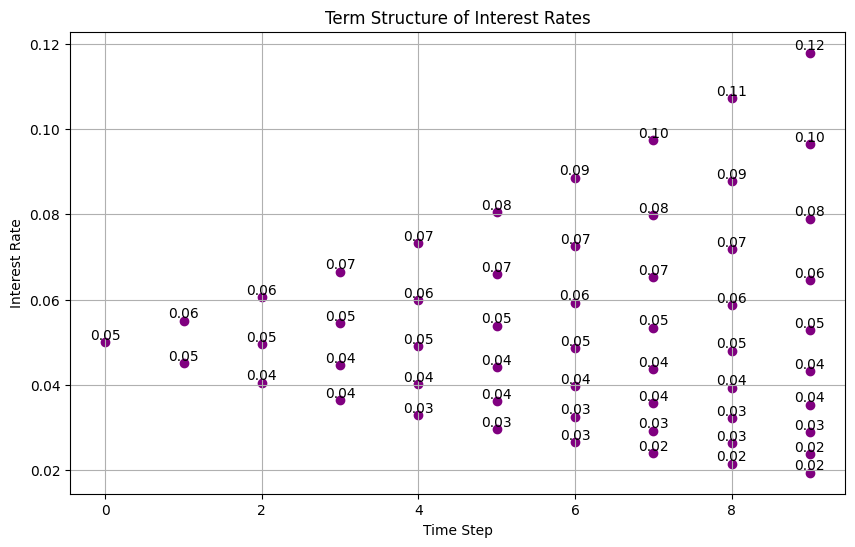

In [45]:



# Plotting the term structure of interest rates
plt.figure(figsize=(10, 6))
for i in range(n+1):
    for j in range(i+1):
        plt.scatter(i, term_structure[j, i], color='purple')
        plt.text(i, term_structure[j, i], f'{term_structure[j, i]:.2f}', ha='center', va='bottom')
plt.title('Term Structure of Interest Rates')
plt.xlabel('Time Step')
plt.ylabel('Interest Rate')
plt.grid()
plt.show()

## Elementary price lattice

In [52]:
# Elementary price lattice:

elementary = elementary_prices_lattice(r0 = 0.06, u = 1.25, d = 0.9, n = 10)
print("\nElementary Prices Lattice:")
print(elementary)


Elementary Prices Lattice:
[[1.00000000e+00 4.71698113e-01 2.19394471e-01 1.00294615e-01 4.48871006e-02 1.95759757e-02 8.27313213e-03 3.36612190e-03 1.30865248e-03 4.81962880e-04 1.66534650e-04]
 [0.00000000e+00 4.71698113e-01 4.43160180e-01 3.07863786e-01 1.86841584e-01 1.04083830e-01 5.42532193e-02 2.66548649e-02 1.23596497e-02 5.39636752e-03 2.20772917e-03]
 [0.00000000e+00 0.00000000e+00 2.23765708e-01 3.14266533e-01 2.90088602e-01 2.19315221e-01 1.46131169e-01 8.86044642e-02 4.96311913e-02 2.58488700e-02 1.25339974e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.06697362e-01 1.99247117e-01 2.29266379e-01 2.07450993e-01 1.60877412e-01 1.11257862e-01 7.00122967e-02 4.04932336e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.11129986e-02 1.19047559e-01 1.64032044e-01 1.72825278e-01 1.52920685e-01 1.18834018e-01 8.30449145e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.45885466e-02 6.86057318e-02 1.10111716e-01 1.32410940

this pricing can be then used to calculate value of any cash flow that is received at a particular time period.